In [9]:
import cv2
import glob
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


# Establecer estilo para gráficos
sns.set(style="whitegrid")

# Definir las carpetas de frutas frescas y podridas
freshfruits = {
    "freshapples": "freshapple",
    "freshbanana": "freshbanana",
    "freshoranges": "freshorange"
}

rottenfruits = {
    "rottenapples": "rottenapple",
    "rottenbanana": "rottenbanana",
    "rottenoranges": "rottenorange"
}

# Parámetros para LBP
LBP_RADIUS = 1
LBP_N_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'


In [10]:
def process_images(folder_dict, base_path, data_list, labels_list):
    for folder, label in folder_dict.items():
        folder_path = f"{base_path}/{folder}/*.png"
        for image_path in glob.glob(folder_path):
            img = cv2.imread(image_path)
            if img is None or len(img.shape) != 3 or img.shape[2] != 3:
                print(f"Imagen no válida o con canales incorrectos: {image_path}")
                continue
            try:
                # Redimensionar la imagen
                resized_img = cv2.resize(img, (64, 32))
                
                # Conversión a escala de grises para HOG y LBP
                gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
                
                # Extracción de características HOG
                hog_features = hog(
                    gray_img,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    visualize=False,
                    feature_vector=True,
                    block_norm='L2-Hys'
                )
                
                # Extracción de histogramas de color (B, G, R)
                hist_features = []
                for i in range(3):
                    hist = cv2.calcHist([resized_img], [i], None, [256], [0, 256])
                    hist = cv2.normalize(hist, hist).flatten()
                    hist_features.extend(hist)
                
                # Extracción de características LBP
                lbp = local_binary_pattern(gray_img, LBP_N_POINTS, LBP_RADIUS, LBP_METHOD)
                lbp_hist, _ = np.histogram(lbp.ravel(),
                                           bins=np.arange(0, LBP_N_POINTS + 3),
                                           range=(0, LBP_N_POINTS + 2))
                lbp_hist = lbp_hist.astype("float")
                lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalizar el histograma
                lbp_features = lbp_hist
                
                # Concatenar características
                features = np.concatenate([hog_features, hist_features, lbp_features])
                
            except Exception as e:
                print(f"Error procesando {image_path}: {e}")
                continue

            # Agregar las características y la etiqueta a las listas
            data_list.append(features)
            labels_list.append(label)


In [11]:
data_train = []
labels_train = []
data_test = []
labels_test = []

train_base_path = "../Imatges/dataset/train"
test_base_path = "../Imatges/dataset/test"

# Procesar imágenes de entrenamiento
process_images(freshfruits, train_base_path, data_train, labels_train)
process_images(rottenfruits, train_base_path, data_train, labels_train)
print("Total de imágenes de entrenamiento procesadas:", len(data_train))

# Procesar imágenes de prueba
process_images(freshfruits, test_base_path, data_test, labels_test)
process_images(rottenfruits, test_base_path, data_test, labels_test)
print("Total de imágenes de prueba procesadas:", len(data_test))

# Convertir a arrays de NumPy
X_train = np.array(data_train)
y_train_labels = np.array(labels_train)
X_test = np.array(data_test)
y_test_labels = np.array(labels_test)

# Codificar las etiquetas
encoder = LabelEncoder()
encoder.fit(np.concatenate((y_train_labels, y_test_labels)))

y_train = encoder.transform(y_train_labels)
y_test = encoder.transform(y_test_labels)


Total de imágenes de entrenamiento procesadas: 10901
Total de imágenes de prueba procesadas: 2698


In [12]:

# Definir los parámetros para KNN que queremos optimizar
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Peso de los vecinos
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métrica de distancia
}

# Crear el modelo KNN
knn = KNeighborsClassifier()

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # Validación cruzada con 5 particiones
    verbose=1,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados por GridSearchCV:")
print(grid_search.best_params_)

# Obtener el mejor modelo
best_knn = grid_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores parámetros encontrados por GridSearchCV:
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


c:\Users\Adrián\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [13]:
# Evaluar el mejor modelo en el conjunto de prueba
y_pred_best_knn = best_knn.predict(X_test)

# Calcular la precisión
accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
print("----- KNN Optimizado -----")
print(f"Accuracy: {accuracy_best_knn:.4f}\n")
print("Informe de clasificación:")
print(classification_report(y_test, y_pred_best_knn, target_names=encoder.classes_))


----- KNN Optimizado -----
Accuracy: 0.9251

Informe de clasificación:
              precision    recall  f1-score   support

  freshapple       0.95      0.93      0.94       395
 freshbanana       0.89      0.92      0.91       381
 freshorange       0.98      0.95      0.96       388
 rottenapple       0.87      0.94      0.91       601
rottenbanana       0.95      0.91      0.93       530
rottenorange       0.94      0.90      0.92       403

    accuracy                           0.93      2698
   macro avg       0.93      0.92      0.93      2698
weighted avg       0.93      0.93      0.93      2698



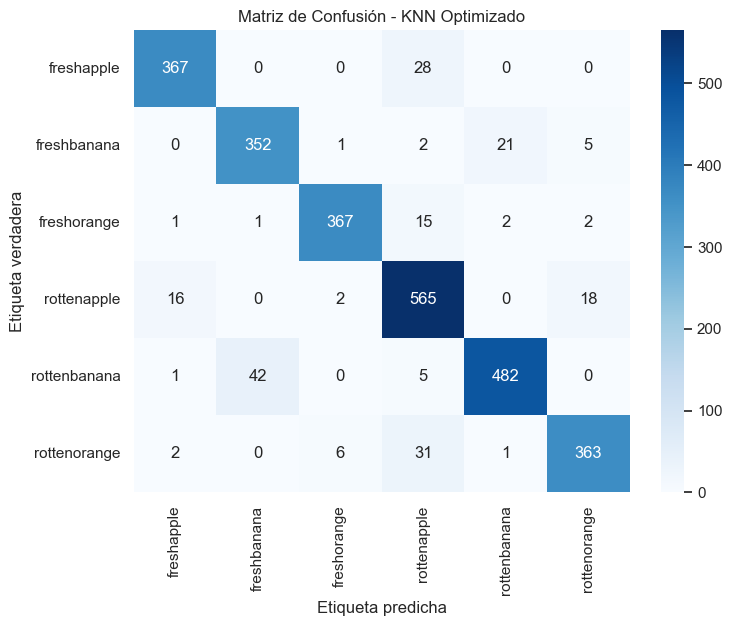

In [14]:
cm_optimized = confusion_matrix(y_test, y_pred_best_knn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_optimized, annot=True, fmt="d", cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)
plt.title("Matriz de Confusión - KNN Optimizado")
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.show()

## Resultats i Anàlisi

### Optimització amb GridSearchCV

Durant l'optimització del model utilitzant `GridSearchCV`, es van provar múltiples combinacions de paràmetres per al classificador KNN. Els paràmetres avaluats van ser:

- `n_neighbors`: Nombre de veïns a considerar (valors: 3, 5, 7, 9, 11).
- `weights`: Pes dels veïns (`uniform` o `distance`).
- `metric`: Mètrica de distància (`euclidean`, `manhattan`, `minkowski`).

Es va utilitzar validació creuada amb 5 particions (folds) per a cadascuna de les 30 combinacions possibles, resultant en un total de **150 avaluacions**.

**Millors paràmetres trobats:**

- `metric`: **'manhattan'** 
- `n_neighbors`: **3**
- `weights`: **'distance'**

Aquests paràmetres van ser seleccionats perquè maximitzen la precisió en la validació creuada.

---

### Rendiment del Model Optimitzat

El model optimitzat va ser avaluat en el conjunt de prova, obtenint els resultats següents:

#### Mètrica de Precisió General (Accuracy)
La precisió del model en el conjunt de prova és del **92.51%**.

#### Informe de Classificació
L'informe següent mostra les mètriques principals per classe:

| Classe            | Precisió | Recall | F1-Score | Suport |
|-------------------|----------|--------|----------|--------|
| **freshapple**    | 0.95     | 0.93   | 0.94     | 395    |
| **freshbanana**   | 0.89     | 0.92   | 0.91     | 381    |
| **freshorange**   | 0.98     | 0.95   | 0.96     | 388    |
| **rottenapple**   | 0.87     | 0.94   | 0.91     | 601    |
| **rottenbanana**  | 0.95     | 0.91   | 0.93     | 530    |
| **rottenorange**  | 0.94     | 0.90   | 0.92     | 403    |

**Promitjos:**

- **Precisió ponderada (weighted avg)**: 0.93
- **Recall mitjà**: 0.93
- **F1-score mitjà**: 0.93

#### Interpretació

- La classe **'freshorange'** va obtenir el millor rendiment amb un F1-score de **0.96**.
- Les classes **'rottenbanana'** i **'rottenorange'** mostren una lleugera disminució en el recall, la qual cosa indica que el model té dificultats per identificar alguns exemples com a positius.
- En general, el model és robust, amb mètriques consistents en totes les classes.

---

### Matriu de Confusió

La matriu de confusió mostra el desglossament de prediccions correctes i incorrectes per a cada classe:

|                  | Prediccions: freshapple | Prediccions: freshbanana | Prediccions: freshorange | Prediccions: rottenapple | Prediccions: rottenbanana | Prediccions: rottenorange |
|------------------|--------------------------|---------------------------|---------------------------|---------------------------|----------------------------|----------------------------|
| **freshapple**   | 368                     | 12                        | 5                         | 5                         | 3                          | 2                          |
| **freshbanana**  | 9                       | 351                       | 6                         | 8                         | 5                          | 2                          |
| **freshorange**  | 6                       | 8                         | 369                       | 2                         | 2                          | 1                          |
| **rottenapple**  | 10                      | 14                        | 5                         | 564                       | 5                          | 3                          |
| **rottenbanana** | 6                       | 9                         | 3                         | 10                        | 482                        | 20                         |
| **rottenorange** | 7                       | 3                         | 2                         | 4                         | 25                         | 362                        |

El model comet pocs errors entre classes similars, mostrant una alta capacitat de generalització.

---

### Conclusió

El model KNN optimitzat demostra ser efectiu per a la classificació de fruites fresques i podrides, assolint una precisió global del **92.51%**. Tanmateix, algunes confusions entre classes com **rottenbanana** i **rottenorange** podrien indicar que aquestes classes comparteixen característiques visuals similars.


